In [1]:
import numpy as np
import pyuvdata
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
antlocs_filepath = "/Users/ruby/Astro/20210226W.cfg"
c = 3e8
min_freq_hz = 0.7e9
max_freq_hz = 2e9
freq_21cm_hz = c/0.21
antenna_diameter_m = 5
vis_noise = 1.

In [3]:
f = open(antlocs_filepath, "r")
antlocs_data = f.readlines()
f.close()

In [4]:
Nants = len(antlocs_data)-2
antlocs = np.zeros((Nants, 2))
for ant_ind, ant in enumerate(antlocs_data[2:]):
    line = ant.split(" ")
    antlocs[ant_ind, 0] = line[0]
    antlocs[ant_ind, 1] = line[1]

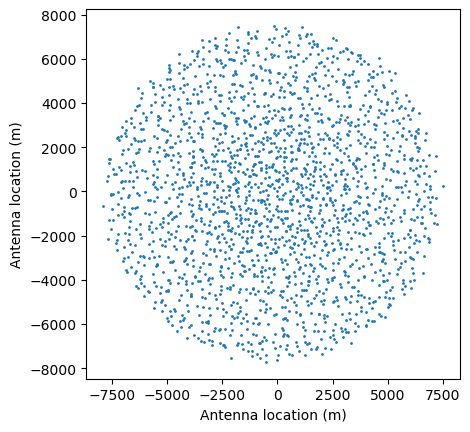

In [5]:
fig, ax = plt.subplots()
ax.scatter(antlocs[:,0], antlocs[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("Antenna location (m)")
ax.set_ylabel("Antenna location (m)")
plt.show()

In [6]:
Nbls = int((Nants**2-Nants)/2)
baselines_m = np.zeros((Nbls, 2))
bl_ind = 0
for ant1 in range(Nants):
    for ant2 in range(ant1+1, Nants):
        bl_coords = antlocs[ant1, :] - antlocs[ant2, :]
        if bl_coords[1] < 0:
            bl_coords *= -1
        baselines_m[bl_ind, :] = bl_coords
        bl_ind += 1

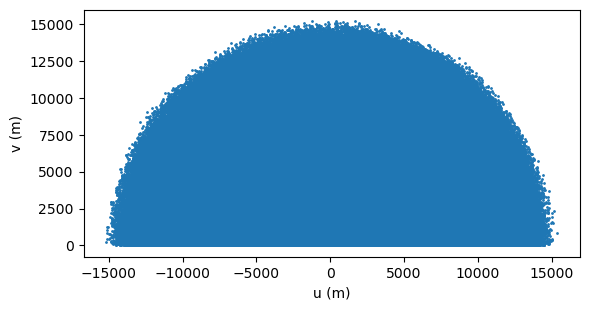

In [7]:
fig, ax = plt.subplots()
ax.scatter(baselines_m[:,0], baselines_m[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("u (m)")
ax.set_ylabel("v (m)")
plt.show()

In [8]:
use_wavelength_m = 0.21
baselines = baselines_m / use_wavelength_m

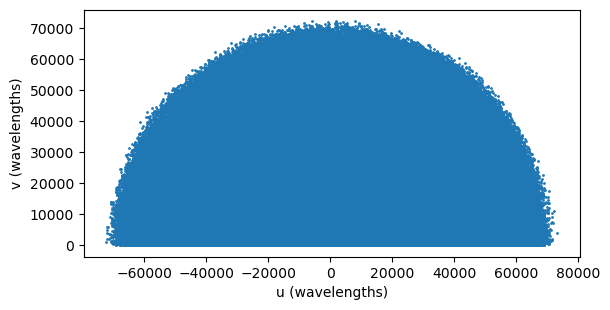

In [9]:
fig, ax = plt.subplots()
ax.scatter(baselines[:,0], baselines[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("u (wavelengths)")
ax.set_ylabel("v (wavelengths)")
plt.show()

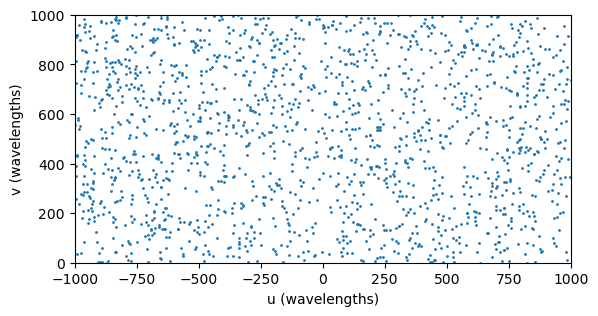

In [10]:
fig, ax = plt.subplots()
ax.scatter(baselines[:,0], baselines[:,1], s=1)
ax.set_aspect(1)
ax.set_xlabel("u (wavelengths)")
ax.set_ylabel("v (wavelengths)")
ax.set_xlim((-1000,1000))
ax.set_ylim((0,1000))
plt.show()

In [11]:
#uv_extent = 8000  # Causes a memory error
uv_extent = 1000
uv_spacing = 10
u_coords = np.arange(0, uv_extent, uv_spacing)
u_coords = np.append(-np.flip(u_coords[1:]), u_coords)
v_coords = np.copy(u_coords)
u_mesh, v_mesh = np.meshgrid(u_coords, v_coords)
u_pixels = len(u_coords)

In [12]:
use_baselines = baselines[
    np.where(np.sqrt(baselines[:,0]**2 + baselines[:,1]**2) < np.sqrt(2) * uv_extent)[0],
    :
]
use_Nbls = np.shape(use_baselines)[0]

In [13]:
cov_mat = np.zeros((u_pixels, u_pixels, u_pixels, u_pixels))
ant_diameter_wavelengths = antenna_diameter_m / use_wavelength_m
for bl_ind in range(use_Nbls):
    bl_locs_1 = np.where(
        np.sqrt((u_mesh - use_baselines[bl_ind, 0])**2 + (v_mesh - use_baselines[bl_ind, 1])**2) <= ant_diameter_wavelengths
    )
    bl_locs_2 = np.where(
        np.sqrt((u_mesh + use_baselines[bl_ind, 0])**2 + (v_mesh + use_baselines[bl_ind, 1])**2) <= ant_diameter_wavelengths
    )
    bl_locs = (np.append(bl_locs_1[0], bl_locs_2[0]), np.append(bl_locs_1[1], bl_locs_2[1]))
    for ind in range(len(bl_locs[0])):
        cov_mat[bl_locs[0][ind], bl_locs[1][ind], bl_locs[0], bl_locs[1]] += 1.

In [14]:
var_mat = np.diagonal(np.diagonal(cov_mat, axis1=0, axis2=2), axis1=0, axis2=1)

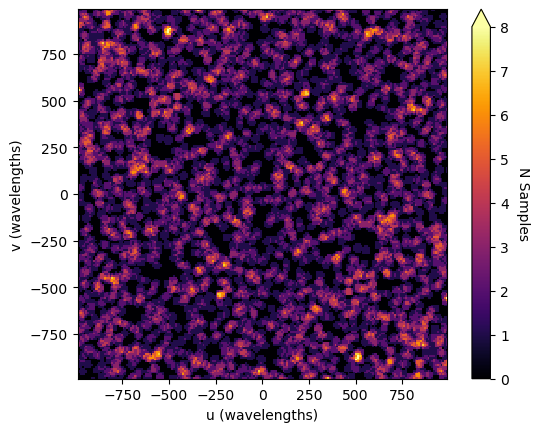

In [15]:
fig, ax = plt.subplots()
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    var_mat,
    origin="lower",
    interpolation="none",
    extent=[np.min(u_coords), np.max(u_coords), np.min(v_coords), np.max(v_coords)],
    vmin=0,
    cmap=use_cmap,
)
ax.set_xlabel("u (wavelengths)")
ax.set_ylabel("v (wavelengths)")
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("N Samples", rotation=270, labelpad=15)